# LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn, save, load
import torch.optim as optim
from torch.utils.data import DataLoader
import random
from sklearn.metrics import precision_score, recall_score, fbeta_score
from tabulate import tabulate
import copy
import torch.nn.init as init
from sklearn.linear_model import LinearRegression
from torch.optim.lr_scheduler import StepLR
from itertools import product
import matplotlib.patches as patches

# DEVICE CONFIGURATION

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# CUSTOMED WINNER TAKES ALL MECHANISM

In [ ]:
def winner_takes_all(decoded,factor):
    winner_takes_all = decoded.clone()
    batch_size, num_classes = decoded.size()

    # Accumulates most of the weight in the statistically most significant neuron(after softmax) for every batch of 6 neurons
    #(depends on the number of neurons needed to represent every letter)

    for i in range(batch_size):
        for j in range(0, num_classes, 6):
            # Find the index and value of the maximum in each 6-element section
            max_val, max_idx = torch.max(decoded[i, j:j+6], 0)

            # Sum the values of the other 5 elements
            sum_of_others = torch.sum(decoded[i, j:j+6]) - max_val

            # Add the sum of other values to the maximum value
            cumulative_max_val = max_val + sum_of_others

            # Set the maximum value to the enhanced value (general normalization after trials)
            winner_takes_all[i, j + max_idx] = (cumulative_max_val * batch_size * threshold )/ (bits_per_letter * factor)

    return winner_takes_all

# FIRST ORDER NETWORK ARCHITECTURE DEFINITION

In [ ]:
class FirstOrderNetwork(nn.Module):

    def __init__(self,hidden,factor,gelu):
        super(FirstOrderNetwork, self).__init__()

        # Encoder Layer
        self.enc_linear = nn.Linear(48, hidden)  # 48 -> hidden_layer_size

        # Decoder Layer
        self.dec_linear = nn.Linear(hidden, 48)  # hidden_layer_size -> 48

        self.temperature = 1.0

        #determines the amount of data, factor =1 means that it's the default amount of data, 10 means 10 times the data(input data)
        self.factor=factor

        #activation functions, either GELU for a  smoother gradient transition  or RELU
        if gelu:
          self.activation=torch.nn.GELU()
        else:
          self.activation=torch.relu
        self.sigmoid = torch.sigmoid
        self.softmax = torch.nn.Softmax(dim=1)  # Softmax activation - usually for winner takes all problems, based on statistically probability on
        self.tanh=torch.tanh

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        # Initialize weights uniformly between -1.0 and 1.0
        init.uniform_(self.enc_linear.weight, -1.0, 1.0)
        init.uniform_(self.dec_linear.weight, -1.0, 1.0)

    def forward(self, x):
        # Encoder, uses temperature parameter
        encoded = self.activation(self.enc_linear(x)/self.temperature)

        # Decoder
        final_output = self.softmax(self.dec_linear(encoded))  # Using softmax to normalize

        # Apply winner takes all function
        final_output = winner_takes_all(final_output, self.factor)

        return final_output

# SECOND ORDER NETWORK ARCHITECTURE DEFINITION

In [ ]:
class SecondOrderNetwork(nn.Module):
    def __init__(self,gelu):
        super(SecondOrderNetwork, self).__init__()

        # The input is the difference of two 48-unit vectors, so input size is still 48
        self.input_layer = nn.Linear(48, 48)
        self.output_layer = nn.Linear(48, 48)
        #The comparisson layer of input and output of the 1st order network
        self.comparison_layer = nn.Linear(48, 48)

        # These units are connected to one unit representing high and low wagers
        self.high_wager = nn.Linear(48, 1)
        self.low_wager = nn.Linear(48, 1)

        #activation functions
        if gelu:
          self.activation=torch.nn.GELU()
        else:
          self.activation=torch.relu
        self.sigmoid = torch.sigmoid
        self.softmax = torch.nn.Softmax(dim=1)  # Softmax activation - usually for winner takes all problems
        self.tanh=torch.tanh

        # Initialize weights
        self._init_weights()

    def _init_weights(self):

        # Wager layer weights can be initialized uniformly
        init.uniform_(self.input_layer.weight, -1.0, -1.0)
        init.uniform_(self.output_layer.weight, 1.0, 1.0)

        init.uniform_(self.comparison_layer.weight, 0.0, 0.1)
        init.uniform_(self.high_wager.weight, 0.0, 0.1)
        init.uniform_(self.low_wager.weight, 0.0, 0.1)

    def forward(self, first_order_input, first_order_output):

        init.uniform_(self.input_layer.weight, -1.0, -1.0)
        init.uniform_(self.output_layer.weight, 1.0, 1.0)

        # Create a comparison matrix by subtracting the output from the input
        matrix_input= self.activation(self.input_layer(first_order_input))
        matrix_output= self.activation(self.output_layer(first_order_output))

        comparison_matrix = matrix_input - matrix_output

        batch_size, num_classes = comparison_matrix.size()

        #comparisson matrix
        comparison_out = self.activation(self.comparison_layer(comparison_matrix))

        #high wager, low wager mechanism, only 1 is returned
        high_wager = self.sigmoid(self.high_wager(comparison_out))
        low_wager = self.sigmoid(self.low_wager(comparison_out))

        if high_wager.sum() > (   (batch_size * threshold) / (bits_per_letter)   ):
          return high_wager
        else:
          return low_wager

# FUNCTIONS THAT CREATES RANDOM , GRAMMAR A, AND GRAMMAR B WORDS



In [ ]:
#GRAMMAR A AND GRAMMAR B WORDS ARE BUILD BASED ON THE ARCHITECTURE SHOWN ON FIGURE 5.1, FROM THE PAPER "Five Transfer of implicit knowledge across domains: How
#implicit and how abstract?" (DIENES, 1997)

#mechanism to generate a random word with the dominion of the allowed letter within grammar A and B
def Generate_Word_Random():
    grammar_word = ""
    number_letters = random.randint(3, 8)
    allowed_letters = ["x", "v", "m", "t", "r"]  # Letters from Grammar A and B
    while len(grammar_word) < number_letters:
        current_letter = random.choice(allowed_letters)
        grammar_word += current_letter
    return grammar_word

#mechanim to generate a grammar A word based on the grammar A architecture of the Dienes, 1997
def Generate_Grammar_A():
  grammar_A_word=""
  number_letters=random.randint(3,8)
  position=1
  i=0
  while len(grammar_A_word) < number_letters:

    current_path = random.randint(1, 2)

    (grammar_A_word := grammar_A_word + "x", position := 2) if (position, current_path) == (1, 1) else (grammar_A_word := grammar_A_word + "v", position := 3) if (position, current_path) == (1, 2) else None

    current_path = random.randint(1, 2)
    if len(grammar_A_word)==number_letters:
      break
    (grammar_A_word := grammar_A_word + "m", position := 2) if (position, current_path) == (2, 1) else (grammar_A_word := grammar_A_word + "x", position := 4) if (position, current_path) == (2, 2) else None

    current_path = random.randint(1, 2)
    if len(grammar_A_word)==number_letters:
      break
    (grammar_A_word := grammar_A_word + "t", position := 3) if (position, current_path) == (3, 1) else (grammar_A_word := grammar_A_word + "v", position := 5) if (position, current_path) == (3, 2) else None

    current_path = random.randint(1, 2)
    if len(grammar_A_word)==number_letters:
      break
    (grammar_A_word := grammar_A_word + "t", position := 4) if (position, current_path) == (4, 1) else (grammar_A_word := grammar_A_word + "m", position := 6) if (position, current_path) == (4, 2) else None

    current_path = random.randint(1, 2)
    if len(grammar_A_word)==number_letters:
      break
    (grammar_A_word := grammar_A_word + "r", position := 3) if (position, current_path) == (5, 1) else (grammar_A_word := grammar_A_word + "m", position := 6) if (position, current_path) == (5, 2) else None

    if position==6:
      break
  return grammar_A_word

#mechanim to generate a grammar B word based on the grammar B architecture of the Dienes, 1997

def Generate_Grammar_B():
  grammar_B_word=""
  number_letters=random.randint(3,8)
  position=1
  i=0
  while len(grammar_B_word) < number_letters:

    current_path = random.randint(1, 2)

    (grammar_B_word := grammar_B_word + "x", position := 2) if (position, current_path) == (1, 1) else (grammar_B_word := grammar_B_word + "v", position := 3) if (position, current_path) == (1, 2) else None

    current_path = random.randint(1, 2)
    if len(grammar_B_word)==number_letters:
      break
    (grammar_B_word := grammar_B_word + "x", position := 5) if (position, current_path) == (2, 1) else (grammar_B_word := grammar_B_word + "m", position := 3) if (position, current_path) == (2, 2) else None

    current_path = random.randint(1, 2)
    if len(grammar_B_word)==number_letters:
      break
    (grammar_B_word := grammar_B_word + "v", position := 4) if (position, current_path) == (3, 1) else (grammar_B_word := grammar_B_word + "t", position := 5) if (position, current_path) == (3, 2) else None

    current_path = random.randint(1, 2)
    if len(grammar_B_word)==number_letters:
      break
    (grammar_B_word := grammar_B_word + "t", position := 4) if (position, current_path) == (4, 1) else (grammar_B_word := grammar_B_word + "r", position := 2) if (position, current_path) == (4, 2) else None

    current_path = random.randint(1, 2)
    if len(grammar_B_word)==number_letters:
      break

    if position==5:
       if current_path==1:
        grammar_B_word+="r"
       elif len(grammar_B_word)>2:
          break

  return grammar_B_word

#FUNCTION THAT ENCODES THE WORD TO GIVE TO THE NEURAL NETWORK



In [ ]:
# each letter encoded as a unique one-hot vector. Since there are 5 possible letters, each letter could be represented as a 5-dimensional vector (e.g., 'a' = [1, 0, 0, 0, 0], 'b' = [0, 1, 0, 0, 0], etc.).
#A string with a maximum of 8 letters would then be a 40-dimensional vector (8 letters x 5 dimensions per letter).
def encode_word(word):
    # Define the mapping
    mapping = {"x": [1, 0, 0, 0, 0],
               "v": [0, 1, 0, 0, 0],
               "m": [0, 0, 1, 0, 0],
               "t": [0, 0, 0, 1, 0],
               "r": [0, 0, 0, 0, 1]}

    # Initialize the output array with zeros
    encoded = [0] * 48  # 48 elements, all zeros

    # Encode each letter and place it in the output array
    for i, letter in enumerate(word):
        encoded[i*5:(i+1)*5] = mapping[letter]

    return encoded

# FUNCTION THAT MAKES ARRAYS OF WORDS (for pre-training, training, testing)



In [ ]:
#A functiion that makes an array of multiple encoded grammar words, be random, grammar A, or grammar B, returns as tensors
def Array_Words(grammar_type , number):
  list_words=[]
  while len(list_words) < number:

    if grammar_type==1:
      generated= Generate_Word_Random()
    if grammar_type==2:
      generated= Generate_Grammar_A()
    if grammar_type==3:
      generated= Generate_Grammar_B()

    generated_encoded= encode_word(generated)
    list_words.append(generated_encoded)

  list_words=torch.Tensor(list_words).to(device)
  return list_words

# FUNCTION THAT RETURNS SECOND ORDER TARGETS


In [ ]:
#A function that uses input and output of first order networks to return the targets of high wager(1.0) or low wager(0.0), to be used in the training
def target_second(input, output):
    if input.shape != output.shape:
        raise ValueError("Input and output must have the same shape")

    num_rows, num_cols = input.shape
    result = torch.zeros(num_rows)

    for i in range(num_rows):
        # Count the number of 1s in the input row
        input_indexes = (input[i] == 1).nonzero(as_tuple=True)[0]
        num_ones = input_indexes.size(0)

        # Get the indexes of the top x values in the output row
        _, output_indexes = torch.topk(output[i], num_ones)

        # Compare and set the result
        if set(input_indexes.tolist()) == set(output_indexes.tolist()):
            result[i] = 1.0

    wager = torch.Tensor(result).to(device)
    return wager

#PRECISION


In [ ]:
#evaluation function of utility of the training. Calculates precision based    , True_positives /  ( True_positives +  False_positives)
def calculate_precision(patterns_tensor, output_first_order):
    # Initialize counters for true positives (tp) and false positives (fp)
    tp_input = 0
    fp_input = 0
    threshold_precision=0.25

    for i in range(len(patterns_tensor)):

        if abs((patterns_tensor[i] - output_first_order[i]).sum()) <= (threshold_precision*patterns_tensor[i].sum()):
            tp_input += 1
        else:
            fp_input += 1

    precision_input = tp_input / (tp_input + fp_input)

    return precision_input

# Function that performs linear regression

In [ ]:
#calculates linear approximation function to graph on the plots

def perform_linear_regression(epoch_list, precision):
    # Perform linear regression
    X = np.array(epoch_list).reshape(-1, 1)
    y = np.array(precision)
    reg = LinearRegression().fit(X, y)
    y_pred = reg.predict(X)
    return y_pred

#AVERAGE, MAX, MIN FUNCTIONS FOR PLOTS

In [ ]:
#calculate averge over the trained networks over epochs
def calculate_average(network_data, start_network, end_network):
    num_epochs = len(network_data[0])
    average = [0] * num_epochs
    num_networks = end_network - start_network
    for epoch in range(num_epochs):
        sum_loss = sum(network_data[i][epoch] for i in range(start_network, end_network))
        average[epoch] = sum_loss / num_networks
    return average

#calculate max reached over the trained networks over epochs
def calculate_max(network_data, start_network, end_network):
    num_epochs = len(network_data[0])
    maximum = [0] * num_epochs
    for epoch in range(num_epochs):
        maximum[epoch] = max(network_data[i][epoch] for i in range(start_network, end_network))
    return maximum

#calculate max reached over the trained networks over epochs
def calculate_min(network_data, start_network, end_network):
    num_epochs = len(network_data[0])
    minimum = [float('inf')] * num_epochs
    for epoch in range(num_epochs):
        minimum[epoch] = min(network_data[i][epoch] for i in range(start_network, end_network))
    return minimum

#ASSIGNMENT OF FIRST AND SECOND ORDER NETWORK, AND DEFINITION OF CRITERIONS


In [ ]:
#define the architecture, optimizers, loss functions, and schedulers for pre training
def prepare_pre_training(hidden,factor,gelu,stepsize, gam):
  first_order_network = FirstOrderNetwork(hidden,factor,gelu).to(device)
  second_order_network = SecondOrderNetwork(gelu).to(device)

  #Binary Cross-Entropy Loss: especially used in classification tasks, either correctly classified it or not, or correctly high wager or not
  criterion_1 = nn.BCEWithLogitsLoss()
  criterion_2 = nn.BCEWithLogitsLoss()

  # Using Adam optimizer
  optimizer_1 = optim.Adam(first_order_network.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08)
  optimizer_2 = optim.Adam(second_order_network.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08)

  # Learning rate schedulers
  scheduler_1 = StepLR(optimizer_1, step_size=stepsize, gamma=gam)
  scheduler_2 = StepLR(optimizer_2, step_size=stepsize, gamma=gam)

  #to later restore the weights of the 1st order network
  initial_first_order_weights = copy.deepcopy(first_order_network.state_dict())  # Store initial weights

  return first_order_network, second_order_network, criterion_1, criterion_2, optimizer_1, optimizer_2, scheduler_1, scheduler_2, initial_first_order_weights

# PRE TRAINING LOOP

In [ ]:
def pre_train(first_order_network, second_order_network, criterion_1, criterion_2, optimizer_1, optimizer_2, scheduler_1, scheduler_2, initial_first_order_weights, factor , meta):

  precision= np.zeros((n_epochs_pre))

  for epoch in range(n_epochs_pre):

      #generation online of patterns every epoch, and pass over the networks
      patterns_tensor = Array_Words(1, patterns_number_pre*factor)
      output_first_order = first_order_network(patterns_tensor)
      output_second_order = second_order_network(patterns_tensor, output_first_order).squeeze()
      order_2_tensor_without = target_second(patterns_tensor, output_first_order)

      #backprop over layers to update the weights
      loss_2 = criterion_2(output_second_order, order_2_tensor_without).requires_grad_()
      loss_1 = criterion_1(output_first_order, patterns_tensor).requires_grad_()

      #pass if the 2nd order layer will be trained, it's used when we change the hyperparameter to evaluate performance when we don't use the wagering mechanism

      if meta==True:
        loss_2.backward(retain_graph=True)
        optimizer_2.step()
        optimizer_2.zero_grad()

      loss_1.backward(retain_graph=True)
      optimizer_1.step()
      optimizer_1.zero_grad()

      epoch_1_order[epoch] = loss_1.detach().item()
      epoch_2_order[epoch] = loss_2.detach().item()

      precision[epoch] = calculate_precision(patterns_tensor, output_first_order)

      # Update learning rate, using a scheduler
      scheduler_1.step()
      if meta==True:
        scheduler_2.step()

  first_order_network.load_state_dict(initial_first_order_weights) #reload initial 1st order weights

  return first_order_network , second_order_network , epoch_1_order , epoch_2_order, precision

# PRE-TRAINING PLOTS

In [ ]:
def pre_train_plots(epoch_1_order, epoch_2_order, precision , title):

  # LOSS PLOTS

  # Set up the plot with 1 row and 2 columns
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # Adjust the figure size as needed

  # First graph for 1st Order Network
  ax1.plot(epoch_list, epoch_1_order, linestyle='--', marker='o', color='g')
  ax1.legend(['1st Order Network'])
  ax1.set_xlabel('Number of EPOCH - PRETRAINING PHASE')
  ax1.set_ylabel('LOSS')

  # Second graph for 2nd Order Network
  ax2.plot(epoch_list, epoch_2_order, linestyle='--', marker='o', color='b')
  ax2.legend(['2nd Order Network'])
  ax2.set_xlabel('Number of EPOCH - PRETRAINING PHASE')
  ax2.set_ylabel('LOSS')


  plt.suptitle(title, fontsize=16)

  # Display the plots side by side
  plt.tight_layout()
  plt.savefig('ArtificialGrammar_Pre_training_Loss_{}.png'.format(title.replace(" ", "_").replace("/", "_")), bbox_inches='tight')
  plt.show()
  plt.close(fig)

  #PRECISION PLOTS
  fig, ax = plt.subplots(1, 1, figsize=(8, 6))  # Adjust the figure size as needed

  ax.plot(epoch_list, precision, linestyle='--', marker='o', color='r', label='Precision')
  ax.set_xlabel('Number of EPOCH - PRETRAINING PHASE')
  ax.set_ylabel('Precision')

  # Perform linear regression
  y_pred = perform_linear_regression(epoch_list, precision)
  # Plot the linear function
  ax.plot(epoch_list, y_pred, linestyle='-', color='b', label='Linear Fit')

  # Display the legend
  ax.legend()

  plt.suptitle(title, fontsize=16)

  # Display the plot
  plt.tight_layout()
  plt.savefig('ArtificialGrammar_Pre_training_Precision_{}.png'.format(title.replace(" ", "_").replace("/", "_")), bbox_inches='tight')
  plt.show()
  plt.close(fig)

# MODEL LOADING FOR TRAINING AND SET UP OF THE 30 NETWORKS

In [ ]:
def create_networks(first_order_network , second_order_network,hidden,factor,gelu,stepsize, gam):
  #SAVING THE MODELS
  PATH = './cnn1.pth'
  PATH_2 = './cnn2.pth'

  #save the weights of the pretrained networks
  torch.save(first_order_network.state_dict(), PATH)
  torch.save(second_order_network.state_dict(), PATH_2)

  num_networks=30
  networks = []

  for i in range(num_networks):
      loaded_model_trai = FirstOrderNetwork(hidden,factor,gelu)
      loaded_model_2_trai = SecondOrderNetwork(gelu)

      loaded_model_trai.load_state_dict(torch.load(PATH))
      loaded_model_2_trai.load_state_dict(torch.load(PATH_2))

      loaded_model_trai.to(device)
      loaded_model_2_trai.to(device)

      criterion_1 = nn.BCEWithLogitsLoss()
      criterion_2 =   nn.BCEWithLogitsLoss()

      optimizer_1 = optim.Adam(loaded_model_trai.parameters(),  lr=learning_rate, betas=(0.9, 0.999), eps=1e-08)
      optimizer_2 = optim.Adam(loaded_model_2_trai.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08)

      # Learning rate schedulers
      scheduler_1 = StepLR(optimizer_1, step_size=stepsize, gamma=gam)
      scheduler_2 = StepLR(optimizer_2, step_size=stepsize, gamma=gam)

      networks.append([loaded_model_trai, loaded_model_2_trai , criterion_1 , criterion_2 , optimizer_1 , optimizer_2 , scheduler_1, scheduler_2])

  return networks

# TRAINING






In [ ]:
def training(networks, n_epochs_train, start_network, end_network, factor, meta):

  n_epochs_tra_1= n_epochs_train

  epoch_list = list(range(1, n_epochs_tra_1 + 1))
  epoch_1_order= np.zeros(( len(networks),n_epochs_tra_1))
  epoch_2_order= np.zeros((  len(networks),n_epochs_tra_1))
  precision_high = np.zeros((  len(networks),n_epochs_tra_1))

  for network in range( start_network, end_network):

    for epoch in range(n_epochs_tra_1):

      patterns_tensor = Array_Words(2, 45 * factor)

      output_first_order = networks[network][0](patterns_tensor)
      output_second_order = networks[network][1]( patterns_tensor, output_first_order).squeeze()

      order_2_tensor = target_second(patterns_tensor , output_first_order)
      loss_2 = networks[network][3](   output_second_order  , order_2_tensor     ).requires_grad_()
      loss_1 = networks[network][2](   output_first_order  ,   patterns_tensor    ).requires_grad_()

      if meta==True:
        loss_2.backward(retain_graph=True)
        networks[network][5].step()
        networks[network][5].zero_grad()

      loss_1.backward()
      networks[network][4].step()
      networks[network][4].zero_grad()

      epoch_1_order[network][epoch] = loss_1.detach().item()
      epoch_2_order[network][epoch] = loss_2.detach().item()
      precision_high[network][epoch]= calculate_precision(patterns_tensor, output_first_order)

      # Update learning rate
      networks[network][6].step()
      if meta==True:
        networks[network][7].step()

  flattened_loss_1 = [item for sublist in epoch_1_order for item in sublist]
  flattened_precision = [item for sublist in precision_high for item in sublist]

  return networks, epoch_list, epoch_1_order, epoch_2_order, precision_high, flattened_loss_1, flattened_precision

def training_plots(epoch_list, epoch_1_order, epoch_2_order,precision_high,start_network, end_network ,title):
  epoch_list_high=epoch_list
  avg_1_order = calculate_average(epoch_1_order, start_network, end_network)
  max_1_order = calculate_max(epoch_1_order, start_network, end_network)
  min_1_order = calculate_min(epoch_1_order, start_network, end_network)

  avg_2_order = calculate_average(epoch_2_order, start_network, end_network)
  max_2_order = calculate_max(epoch_2_order, start_network, end_network)
  min_2_order = calculate_min(epoch_2_order, start_network, end_network)

  avg_precision_high=calculate_average(precision_high, start_network, end_network)
  max_precision_high=calculate_max(precision_high, start_network, end_network)
  min_precision_high=calculate_min(precision_high, start_network, end_network)


  # Set up the plot with 1 row and 2 columns
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # Adjust the figure size as needed

  # First graph for 1st Order Network
  ax1.plot(epoch_list, avg_1_order,  linestyle='--', marker='o', color='b' , label='Average Loss - 1st Order')
  ax1.fill_between(epoch_list, min_1_order, max_1_order, color='b', alpha=0.2)
  ax1.legend(['Average loss 1st Order Network'])
  ax1.set_ylabel('LOSS')
  # Second graph for 2nd Order Network
  ax2.plot(epoch_list, avg_2_order,  linestyle='--', marker='o', color='r' , label='Average Loss - 2nd Order')
  ax2.fill_between(epoch_list, min_2_order, max_2_order, color='r', alpha=0.2)
  ax2.legend(['Average loss 2nd Order Network'])
  ax2.set_ylabel('LOSS')

  plt.suptitle(title, fontsize=16)

  # Display the plots side by side
  if start_network==0:
    ax1.set_xlabel('Number of EPOCH - TESTING PHASE (high consciousness)')
    ax2.set_xlabel('Number of EPOCH - TESTING PHASE (high consciousness)')
    plt.tight_layout()
    plt.savefig('ArtificialGrammar_training_Loss_High_Consciousness_{}.png'.format(title.replace(" ", "_").replace("/", "_")), bbox_inches='tight')
  else:
    ax1.set_xlabel('Number of EPOCH - TESTING PHASE (low consciousness)')
    ax2.set_xlabel('Number of EPOCH - TESTING PHASE (low consciousness)')
    plt.tight_layout()
    plt.savefig('ArtificialGrammar_training_Loss_Low_Consciousness_{}.png'.format(title.replace(" ", "_").replace("/", "_")), bbox_inches='tight')

  plt.show()
  plt.close(fig)

  # PLOT PRECISION, Linear Regression
  fig, ax = plt.subplots(figsize=(8, 6))  # Adjust the figure size as needed
  ax.plot(epoch_list, avg_precision_high, linestyle='--', marker='o', color='r', label='Average Precision')
  ax.fill_between(epoch_list, min_precision_high, max_precision_high, color='r', alpha=0.2, label='Precision Range')
  y_pred_linear = perform_linear_regression(epoch_list, avg_precision_high)
  ax.plot(epoch_list, y_pred_linear, linestyle='-', color='b', label='Linear Fit')
  ax.set_ylabel('Precision')

  plt.suptitle(title, fontsize=16)

  if start_network==0:
    ax.set_xlabel('Number of EPOCH - TESTING PHASE (high consciousness)')
    ax.legend()
    plt.tight_layout()
    plt.savefig('ArtificialGrammar_training_Precision_High_Consciousness_{}.png'.format(title.replace(" ", "_").replace("/", "_")), bbox_inches='tight')
  else:
    ax.set_xlabel('Number of EPOCH - TESTING PHASE (low consciousness)')
    ax.legend()
    plt.tight_layout()
    plt.savefig('ArtificialGrammar_training_Precision_Low_Consciousness_{}.png'.format(title.replace(" ", "_").replace("/", "_")), bbox_inches='tight')
  plt.show()
  plt.close(fig)

#SCATTER PLOT - TRAINING PHASE

In [ ]:
#plots performance vs 1st order loss of the n trained networks, both high consciousness and low consicousness networks
def training_scatter_plot(flattened_loss_1_high,flattened_loss_1_low, flattened_precision_high,flattened_precision_low,title):
  fig = plt.figure()

  plt.scatter(flattened_loss_1_low, flattened_precision_low, edgecolor='red', facecolors='red', label='Low Consciousness')
  plt.scatter(flattened_loss_1_high, flattened_precision_high, edgecolor='blue', facecolors='none',
              marker='o', label='High Consciousness')

  y_pred_linear = perform_linear_regression(flattened_loss_1_high, flattened_precision_high)
  plt.plot(flattened_loss_1_high, y_pred_linear, linestyle='-', color='b', label='Linear Fit - High Consciousness')

  y_pred_linear = perform_linear_regression(flattened_loss_1_low, flattened_precision_low)
  plt.plot(flattened_loss_1_low, y_pred_linear, linestyle='-', color='r', label='Linear Fit - Low Consciousness')

  plt.xlabel('Loss 1st order Network')
  plt.ylabel('Precision')
  plt.title('Loss vs Precision - TRAINING PHASE')
  plt.grid(True)

  plt.legend()

  plt.suptitle(title, fontsize=16)

  plt.tight_layout()
  plt.savefig('ArtificialGrammar_training_Scatter_plot_{}.png'.format(title.replace(" ", "_").replace("/", "_")), bbox_inches='tight')
  plt.show()
  plt.close(fig)

# TESTING LOOP

In [ ]:
def testing(networks, factor):
  #Model loading and evaluation set up
  for network in range(len(networks)):
    networks[network][0].eval()
    networks[network][1].eval()

  Random_baseline_patterns= Array_Words(1, 60 *factor)
  Random_baseline_patterns = torch.Tensor(Random_baseline_patterns).to(device)

  numbers_networks = list(range(1, 31))
  loss_1_networks= np.zeros(30)
  loss_2_networks= np.zeros(30)
  precision_networks= np.zeros(30)
  random_baseline= np.zeros(30)

  for network in range(len(networks)):


    with torch.no_grad():
      Testing_grammar_A= Array_Words(2, 30 *factor)
      Testing_grammar_B= Array_Words(3, 30*factor )

      Testing_patterns = torch.cat((Testing_grammar_A, Testing_grammar_B), dim=0)
      Testing_patterns= torch.Tensor(Testing_patterns).to(device)

      patterns_tensor= Testing_patterns
      output_first_order = networks[network][0](patterns_tensor)

      output_second_order = networks[network][1]( patterns_tensor , output_first_order ).squeeze()

      order_2_tensor = target_second(patterns_tensor , output_first_order)

      loss_1 = networks[network][2](   output_first_order  ,   patterns_tensor    ).requires_grad_()
      loss_2 = networks[network][3](   output_second_order  , order_2_tensor     ).requires_grad_()


      loss_1_networks[network] = loss_1
      loss_2_networks[network] = loss_2

      precision_networks[network]=  calculate_precision(patterns_tensor, output_first_order)
      random_baseline[network]=  calculate_precision(patterns_tensor, Random_baseline_patterns)

  max_value_high = np.max(precision_networks[0:15])
  max_value_low = np.max(precision_networks[15:30])
  mean_value=np.mean(precision_networks)

  return loss_1_networks, loss_2_networks, precision_networks, random_baseline, numbers_networks, max_value_high, max_value_low, mean_value

#PLOTS(TABLE AND SCATTER PLOT) - TESTING PHASE

In [ ]:
def plots_testing(random_baseline, precision_networks, loss_1_networks, loss_2_networks, numbers_networks , title):
  #TABLE LOSS AND PRECISION OF NETWORKS AFTER TESTING

  mean_random_baseline = np.mean(random_baseline)

  # Find the index of the lowest precision value
  max_precision_index = np.argmax(precision_networks)
  min_loss_1_index = np.argmin(loss_1_networks)
  min_loss_2_index = np.argmin(loss_2_networks)

  # Set up the plot
  fig, ax = plt.subplots(figsize=(7, 10))
  ax.axis('tight')
  ax.axis('off')
  table_data = []

  # Add header row with different background color
  header_row = ['Network', 'Loss 1', 'Loss 2', 'Precision']
  cell_colors = ['lightyellow', 'lightgray', 'lightgray', 'lightgray']
  table_data.append(header_row)

  for i, (number, loss_1, loss_2, precision_value) in enumerate(zip(numbers_networks, loss_1_networks, loss_2_networks, precision_networks)):
      row_data = [number, f'{loss_1:.3f}', f'{loss_2:.3f}', f'{precision_value:.3f}']
      table_data.append(row_data)

  # Create the table object
  table = ax.table(cellText=table_data, colLabels=None, cellLoc='center', loc='center', cellColours=[cell_colors]*len(table_data))

  # Set background color for title1 cells
  for i, title1 in enumerate(header_row):
      table[0, i].set_facecolor('lightblue')

  for i, title1 in enumerate(header_row):
      table[max_precision_index + 1, i].set_facecolor('lightgreen')

  for i, title1 in enumerate(header_row):
      table[min_loss_1_index + 1, i].set_facecolor('lightgreen')

  for i, title1 in enumerate(header_row):
      table[min_loss_2_index + 1, i].set_facecolor('lightgreen')

  table.auto_set_font_size(False)
  table.set_fontsize(12)
  plt.tight_layout()
  plt.suptitle(title, fontsize=16 , y=0.9)

  plt.savefig('ArtificialGrammar_testing_table_{}.png'.format(title.replace(" ", "_").replace("/", "_")), bbox_inches='tight')
  plt.show()
  plt.close(fig)



  fig = plt.figure()
  std_random_baseline = np.std(random_baseline)
  upper_bound = mean_random_baseline + std_random_baseline
  lower_bound = mean_random_baseline - std_random_baseline

  split_index = len(precision_networks) // 2

  flattened_precision_high = precision_networks[:split_index]
  flattened_precision_low = precision_networks[split_index:]
  flattened_loss_1_high = loss_1_networks[:split_index]
  flattened_loss_1_low = loss_1_networks[split_index:]


  plt.scatter(flattened_loss_1_low, flattened_precision_low, edgecolor='red', facecolors='red', label='Low Consciousness')
  plt.scatter(flattened_loss_1_high, flattened_precision_high, edgecolor='blue', facecolors='none',
              marker='o', label='High Consciousness')

  y_pred_linear = perform_linear_regression(flattened_loss_1_high, flattened_precision_high)
  plt.plot(flattened_loss_1_high, y_pred_linear, linestyle='-', color='b', label='Linear Fit - High Consciousness')

  y_pred_linear = perform_linear_regression(flattened_loss_1_low, flattened_precision_low)
  plt.plot(flattened_loss_1_low, y_pred_linear, linestyle='-', color='r', label='Linear Fit - Low Consciousness')

  plt.axhline(y=mean_random_baseline, color='black', linestyle='--', label='Random Baseline')
  plt.fill_between( (0.2, 1.0), lower_bound, upper_bound, color='black', alpha=0.2)

  plt.xlabel('Loss 1st order Network')
  plt.ylabel('Precision')
  plt.grid(True)

  plt.legend()

  plt.tight_layout()
  plt.suptitle(title, fontsize=16, y=1.1)

  plt.savefig('testing_scatter_plot_{}.png'.format(title.replace(" ", "_").replace("/", "_")), bbox_inches='tight')
  plt.show()
  plt.close(fig)

#MAIN CODE - TRAINING DEFINITION

In [ ]:
def train(hidden , factor, gelu , stepsize , gam , meta):

  #GRAPHIC OF PRETRAINING
  first_order_network, second_order_network, criterion_1, criterion_2, optimizer_1, optimizer_2, scheduler_1, scheduler_2, initial_first_order_weights = prepare_pre_training(hidden,factor,gelu,stepsize, gam)

  first_order_network_pre , second_order_network_pre , epoch_1_order , epoch_2_order, precision = pre_train(first_order_network, second_order_network, criterion_1, criterion_2, optimizer_1, optimizer_2, scheduler_1, scheduler_2, initial_first_order_weights,factor,meta)

  networks = create_networks(first_order_network_pre , second_order_network_pre,hidden,factor,gelu,stepsize, gam)

  networks_high, epoch_list_high, epoch_1_order_high, epoch_2_order_high, precision_high , flattened_loss_1_high, flattened_precision_high = training(networks, 12, 0, 15,factor,meta)

  networks_low, epoch_list_low, epoch_1_order_low, epoch_2_order_low, precision_low,flattened_loss_1_low, flattened_precision_low = training(networks_high, 3, 15, 30,factor,meta)

  loss_1_networks_testing, loss_2_networks_testing, precision_networks_testing, random_baseline_testing, numbers_networks_testing, max_value_high_testing, max_value_low_testing, mean_value_testing = testing(networks_low,factor)

  print(f"Hidden: {hidden}, Factor: {factor}, Gelu? : {gelu}, Step Size: {stepsize}, Gamma Factor: {gam}, Max Value high consciousness: {max_value_high_testing},  Max Value low consciousness: {max_value_low_testing}, Mean Value: {mean_value_testing}")

  # Collect data for plots
  plot_data = {
      'pre_train': (epoch_1_order, epoch_2_order, precision),
      'training_high': (epoch_list_high, epoch_1_order_high, epoch_2_order_high, precision_high),
      'training_low': (epoch_list_low, epoch_1_order_low, epoch_2_order_low, precision_low),
      'training_scatter': (flattened_loss_1_high, flattened_loss_1_low, flattened_precision_high, flattened_precision_low),
      'testing': (random_baseline_testing, precision_networks_testing, loss_1_networks_testing, loss_2_networks_testing, numbers_networks_testing)
  }
  return max_value_high_testing, max_value_low_testing, mean_value_testing, random_baseline_testing, networks, plot_data

def plots(plot_data , title):
  #plot the results of a trained and tested network
  pre_train_plots(*plot_data['pre_train'],title)
  training_plots(*plot_data['training_high'], 0, 15,title)
  training_plots(*plot_data['training_low'], 15, 30,title)
  training_scatter_plot(*plot_data['training_scatter'],title)
  plots_testing(*plot_data['testing'],title)

def plot_scaling_data(plot_data):
    # This function should performance of a network when we scale the data several factors
    factors = plot_data['factors']
    max_values_high = plot_data['max_values_high']
    max_values_low = plot_data['max_values_low']
    mean_values = plot_data['mean_values']
    mean_random_baseline=[]
    upper_bound=[]
    lower_bound=[]
    for i in range(len(plot_data['random_baseline'])):
      mean=np.mean(plot_data['random_baseline'][i])
      std=np.std(plot_data['random_baseline'][i])
      mean_random_baseline.append(mean)
      upper_bound.append(mean+std)
      lower_bound.append(mean-std)

    fig = plt.figure()
    plt.figure()
    plt.plot(factors, max_values_high, linestyle='--', marker='o' , color='yellow',label='Max Value - high consciousness')
    plt.plot(factors, max_values_low, linestyle='--', marker='o' , color='blue',label='Max Value - low consciousness')
    plt.plot(factors, mean_values, linestyle='--', marker='o', color='red', label='Mean Value')

    plt.plot(factors, mean_random_baseline,  linestyle='--', marker='o', color='black' , label='Random Baseline')
    plt.fill_between(factors, lower_bound , upper_bound, color='black', alpha=0.2)
    plt.xlabel('Data Scale Factor')
    plt.ylabel('Value')
    plt.title('Performance Metrics vs Data Scale Factor')
    plt.legend()
    plt.tight_layout()
    plt.savefig('ArtificialGrammar_performance_metrics_vs_data_scale.png', bbox_inches='tight')
    plt.show()
    plt.close(fig)

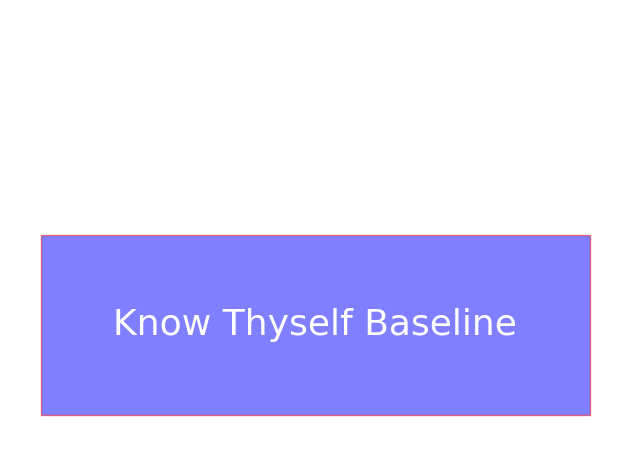

Hidden: 40, Factor: 1, Gelu? : False, Step Size: 1, Gamma Factor: 1.0, Max Value high consciousness: 0.5333333333333333,  Max Value low consciousness: 0.36666666666666664, Mean Value: 0.3638888888888888


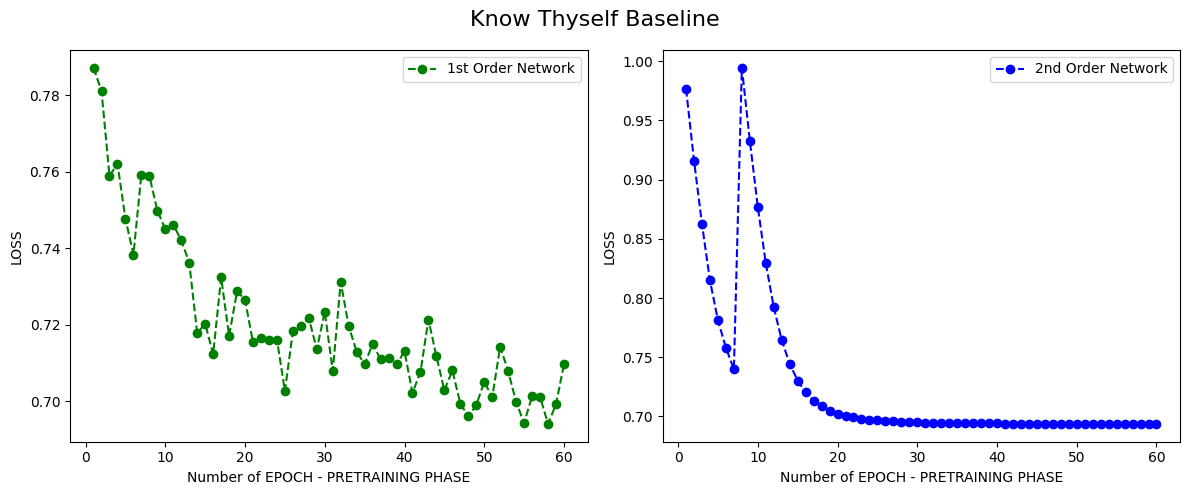

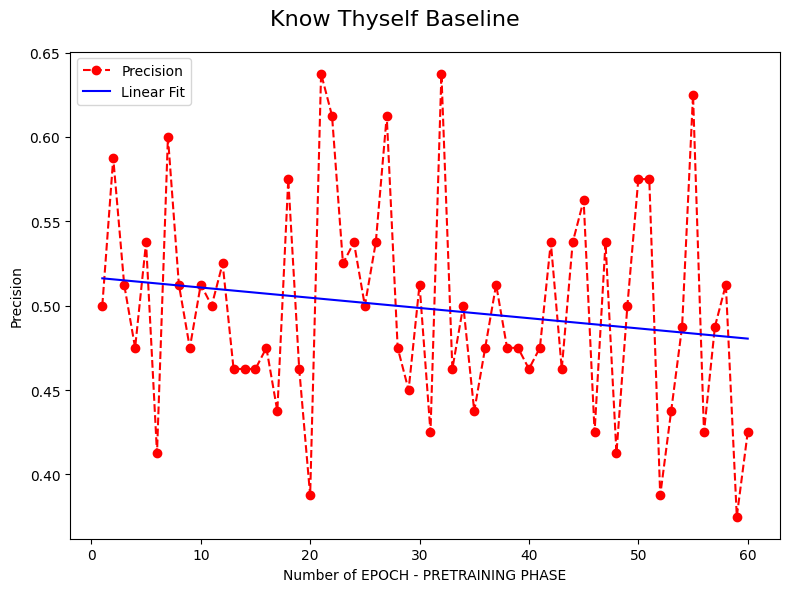

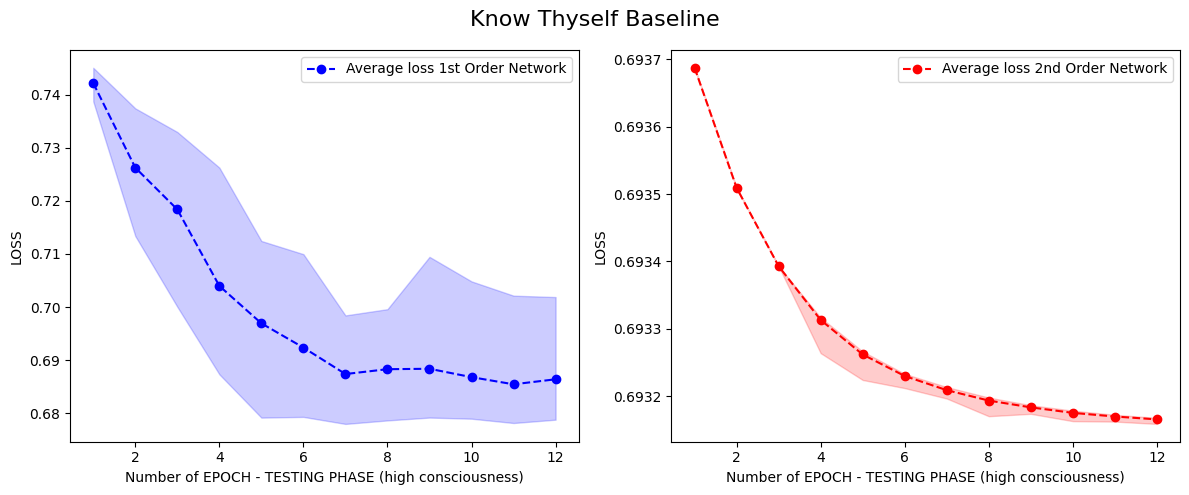

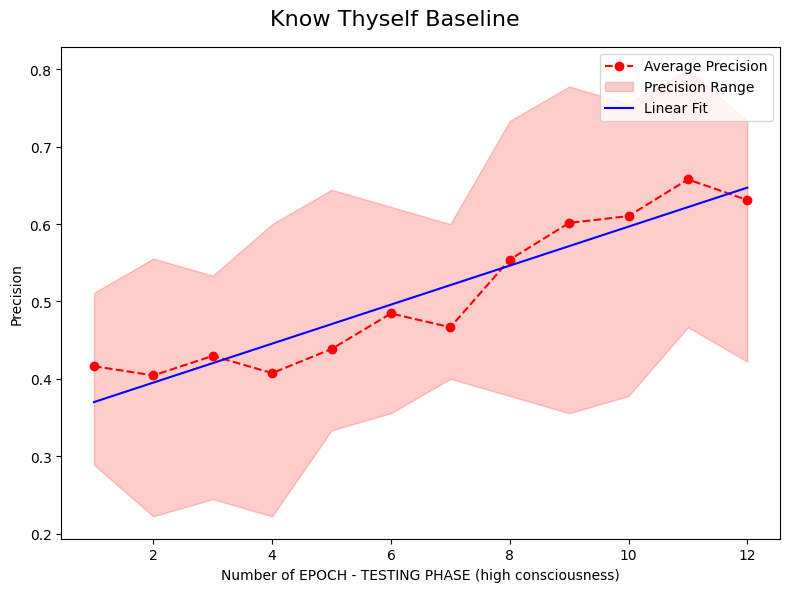

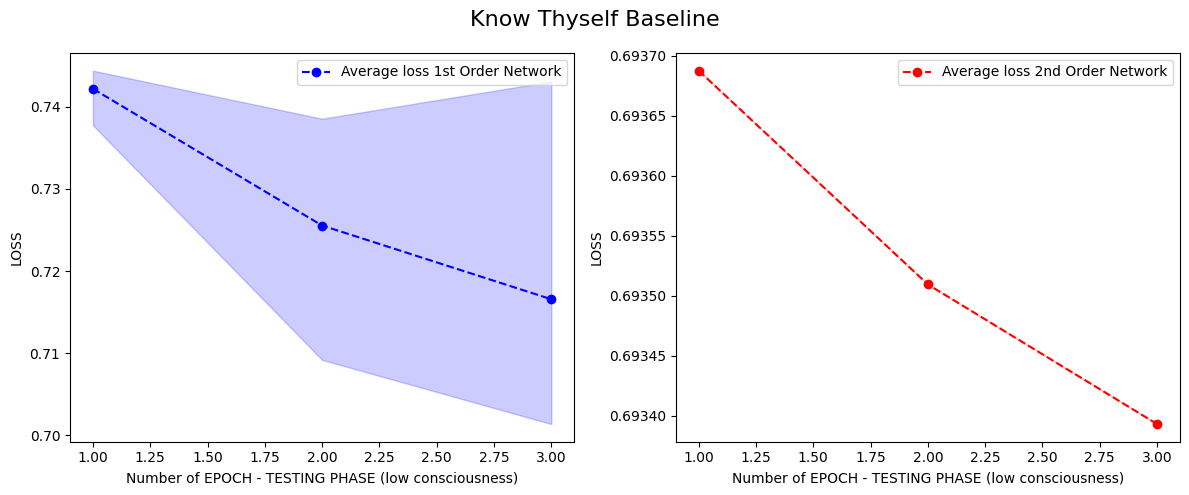

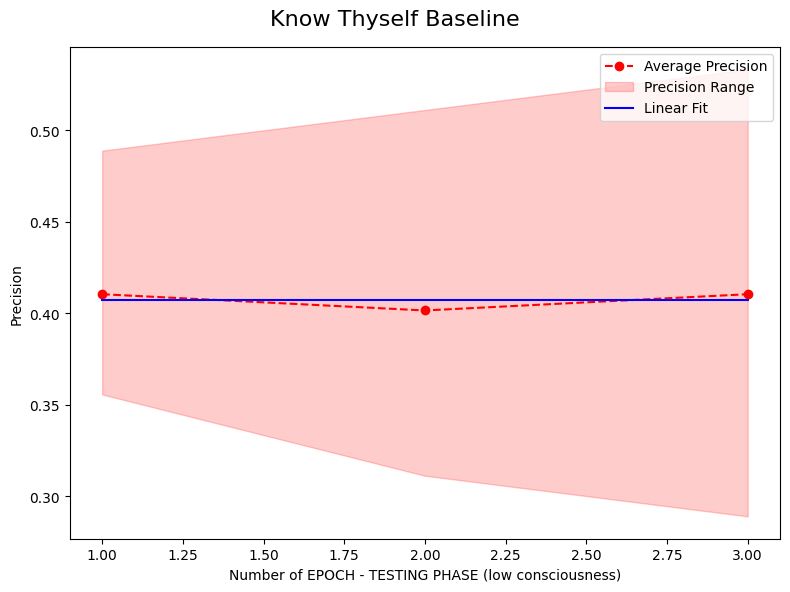

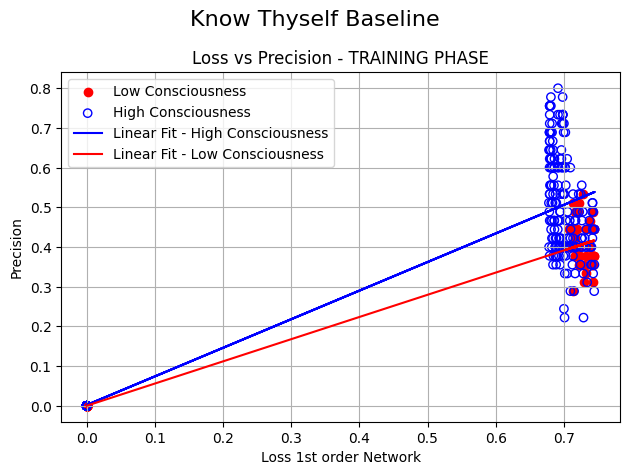

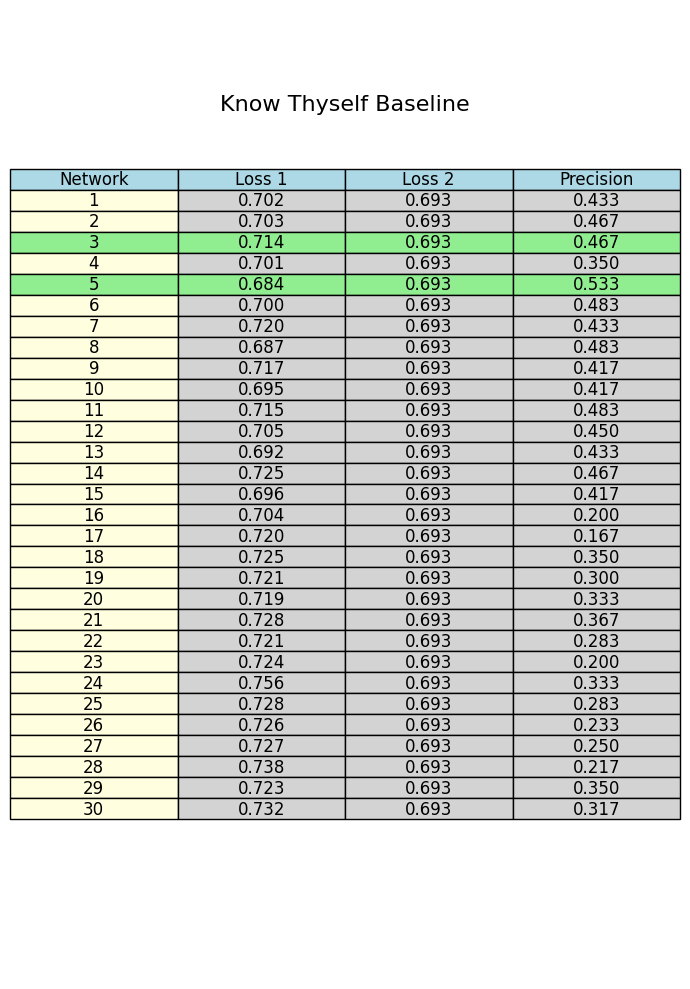

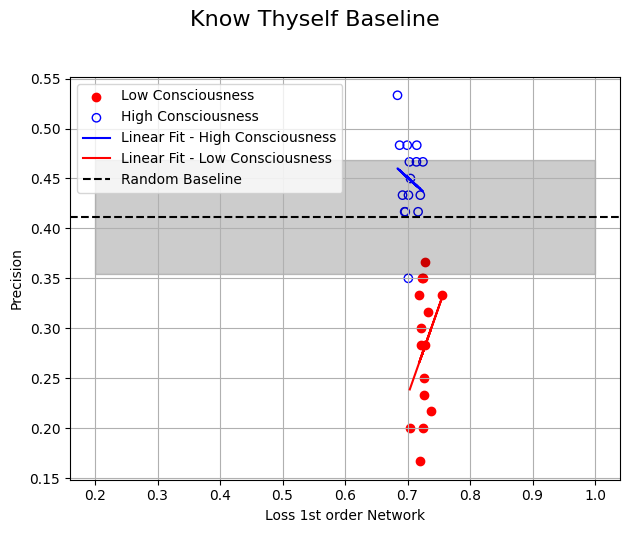

Hidden: 40, Factor: 1, Gelu? : True, Step Size: 1, Gamma Factor: 0.99, Max Value high consciousness: 0.6666666666666666,  Max Value low consciousness: 0.4666666666666667, Mean Value: 0.43833333333333335
Hidden: 40, Factor: 1, Gelu? : True, Step Size: 1, Gamma Factor: 0.99, Max Value high consciousness: 0.6166666666666667,  Max Value low consciousness: 0.4666666666666667, Mean Value: 0.42277777777777786
Hidden: 40, Factor: 1, Gelu? : True, Step Size: 1, Gamma Factor: 0.98, Max Value high consciousness: 0.6166666666666667,  Max Value low consciousness: 0.48333333333333334, Mean Value: 0.3827777777777777
Hidden: 40, Factor: 1, Gelu? : True, Step Size: 1, Gamma Factor: 0.98, Max Value high consciousness: 0.65,  Max Value low consciousness: 0.48333333333333334, Mean Value: 0.39388888888888896
Hidden: 40, Factor: 1, Gelu? : True, Step Size: 1, Gamma Factor: 0.97, Max Value high consciousness: 0.65,  Max Value low consciousness: 0.5833333333333334, Mean Value: 0.4661111111111112
Hidden: 40, F

In [ ]:
def initialize_global():
  global Input_Size_1 , Output_Size_1, Input_Size_2, learning_rate, n_epochs_pre, momentum
  global temperature, patterns_number_pre, colors, threshold, bits_per_letter, n_epochs_pre
  global epoch_list, epoch_1_order, epoch_2_order
  #NETWORKS SIZES
  Input_Size_1= 48
  Output_Size_1=48
  Input_Size_2= 48
  # pre-training and hyperparamentes
  learning_rate = 0.4
  n_epochs_pre = 60
  momentum=0.5
  temperature=1.0
  patterns_number_pre=80
  colors = [
      'b', 'g', 'r', 'c', 'm', 'y', 'k',
      '#FF5733', '#33FF57', '#5733FF', '#33FFFF', '#FF33FF', '#FFFF33',
      '#990000', '#009900', '#000099', '#999900', '#990099', '#009999',
      '#CC0000', '#00CC00', '#0000CC', '#CCCC00', '#CC00CC', '#00CCCC',
      '#FF6666', '#66FF66', '#6666FF', '#FFFF66', '#FF66FF', '#66FFFF'
  ]
  #0.5 threshold for winner takes all mechanism
  threshold=0.5
  #6 bits to represent 1 letter, used in winner takes all
  bits_per_letter=6
  n_epochs_pre = 60
  epoch_list = list(range(1, n_epochs_pre + 1))
  epoch_1_order= np.zeros(n_epochs_pre)
  epoch_2_order= np.zeros(n_epochs_pre)

def title(string):
  #plot the title of the currently trained model, inside a rectangle
  fig, ax = plt.subplots()
  rectangle = patches.Rectangle((0.05, 0.1), 0.9 , 0.4, linewidth=1, edgecolor='r', facecolor='blue', alpha=0.5)
  ax.add_patch(rectangle)
  plt.text(0.5, 0.3, string , horizontalalignment='center', verticalalignment='center', fontsize=26, color='white')
  ax.set_xlim(0, 1)
  ax.set_ylim(0, 1)
  ax.axis('off')

  # Display the plot
  plt.tight_layout()
  plt.show()
  plt.close(fig)


def main():
    hidden_sizes = [ 40 , 50 , 80 , 100 , 120 , 150 , 160 ] #hidden size
    factors = [ 1 ] #factor of data, 10 represents 10 times the amount of data by default in the know thyself paper
    gelus=[ True , False] #True represents using gelu- Gaussian Error Linear Unit , as activation function, False means using relu -Rectified Linear Unit
    step_sizes=[ 1 , 2 , 3 ] #every n number of epochs, the learning rate is updated
    gammas=[ 0.99 , 0.98 , 0.97 , 0.96] #the learning rate is multiplied by this factor every step_sizes as defined with the previous hyperparameter
    metalayers=[ True ] #if true, enables training of the 2nd order layer
    num_iterations = 2 #num of times a certain network configuration will be trained and tested

    #initializations for hyperparameter tunning optimization metric
    best_mean_value = 0
    best_max_high_value = 0
    best_max_low_value = 0
    hyperparameters=list(product(hidden_sizes, factors , gelus  , step_sizes , gammas , metalayers))

    initialize_global()
    title_1="Know Thyself Baseline"
    title(title_1)
    max_value_high, max_value_low, mean_value, random_baseline_testing, networks, plot_data = train(40, 1, False, 1, 1.0, True)
    plots(plot_data , title_1)

    for index in range(len(hyperparameters)):
        for _ in range(num_iterations):
          initialize_global()
          max_value_high_testing, max_value_low_testing, mean_value_testing,random_baseline_testing, networks, plot_data = train(
            hyperparameters[index][0],
            hyperparameters[index][1],
            hyperparameters[index][2],
            hyperparameters[index][3],
            hyperparameters[index][4],
            hyperparameters[index][5])

          #hyperparameter tunning optimization metric, avergae over max of both high consciousness, low consciousness, and the mean of performance over all trained networks
          if np.mean([max_value_high_testing, max_value_low_testing , mean_value_testing]) > np.mean([best_max_high_value,best_max_low_value ,best_mean_value]):
                best_max_high_value= max_value_high_testing
                best_max_low_value= max_value_low_testing
                random_baseline = random_baseline_testing
                best_mean_value= mean_value_testing
                best_networks = networks
                best_plot_data = plot_data
                best_hidden_size = hyperparameters[index][0]
                best_factor = hyperparameters[index][1]
                best_activation = hyperparameters[index][2]
                best_step_size = hyperparameters[index][3]
                best_gamma = hyperparameters[index][4]
                best_metalayer = hyperparameters[index][5]

    print(f"Best hidden: {best_hidden_size}, Best factor: {best_factor}, Best activation: {best_activation}, Best step size: {best_step_size}, Best gamma: {best_gamma}, Best metalayer: {best_metalayer}, Best Max Value high consciousness: {best_max_high_value}, Best Max Value low consciousness: {best_max_low_value}, Best Mean Value: {best_mean_value}")
    title_2="Best Model w/tunning"
    title(title_2)
    plots(best_plot_data , title_2)

    #Non metalayer testing
    initialize_global()
    max_value_high, max_value_low, mean_value, random_baseline_testing, networks, plot_data = train(best_hidden_size, best_factor, best_activation, best_step_size, best_gamma, False)
    title_3="with no metalayer"
    title(title_3)
    plots(plot_data , title_3)

    # Train models with scaled data
    scale_factors = range(1, 101, 3)
    max_values_high = []
    max_values_low = []
    mean_values = []
    random_baseline_matrix=[]

    for factor_scale in scale_factors:
        initialize_global()
        max_value_high, max_value_low, mean_value, random_baseline_testing, _, _ = train(best_hidden_size, factor_scale, best_activation, best_step_size, best_gamma, best_metalayer)
        max_values_high.append(max_value_high)
        max_values_low.append(max_value_low)
        mean_values.append(mean_value)
        random_baseline_matrix.append(random_baseline_testing)

    # Plotting the results
    plot_data = {
        'factors': list(scale_factors),
        'max_values_high': max_values_high,
        'max_values_low': max_values_low,
        'mean_values': mean_values,
        'random_baseline': random_baseline_matrix
    }

    title("Data Scaling Performance")
    plot_scaling_data(plot_data)

main()